# Compare Auxtel Fitted Spectra and comparison with Merra2

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-30
- last update : 2024-01-30
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

# Read pandas Series

In [4]:
files = [ "Data_Auxtel_Spectro/selected_1jan-20feb2023/out_allfittedparams_selected_1jan-28feb2023.csv", 
          "Data_Auxtel_Spectro/selected_1march-14sept2023/out_allfittedparams_selected_1march-14sept2023.csv",
          "Data_Auxtel_Spectro/selected_27sept-07dec2023/out_allfittedparams_selected_27sept-07dec2023.csv"
        ]
N = len(files)

In [5]:
all_df = [pd.read_csv(files[idx], index_col=0, header=0) for idx in range(N)]

In [6]:
df = pd.concat(all_df)

In [7]:
df.head()

,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,...,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y,filtered
DATE-OBS,,,,,,,,,,,,,,,,,,,,,
2023-01-18 02:33:44.320492641+00:00,2023011700238,-64,2,1066,3,True,HD185975,-0.000065,holo4_003,0.142843,...,0.031225,1.209370,0.028397,186.800590,0.004384,1.005575,0.0,0.0,0.0,True
2023-01-18 02:34:27.138506292+00:00,2023011700239,-64,2,1066,3,True,HD185975,-0.000065,holo4_003,0.137532,...,0.030546,1.211153,0.035841,186.824461,0.005769,0.950434,0.0,0.0,0.0,True
2023-01-18 02:43:58.366995924+00:00,2023011700243,-64,2,1067,3,True,HD074000,0.000687,holo4_003,0.165397,...,0.049876,1.735232,0.044659,186.943501,0.007737,1.012003,0.0,0.0,0.0,True
2023-01-18 02:44:41.368008749+00:00,2023011700244,-64,2,1066,3,True,HD074000,0.000687,holo4_003,0.169342,...,0.054533,1.577680,0.047941,186.878151,0.008278,1.035143,0.0,0.0,0.0,True
2023-01-18 03:05:56.221990758+00:00,2023011700249,-64,2,1066,3,True,HD185975,-0.000065,holo4_003,0.141368,...,0.028708,1.293266,0.032606,186.769243,0.005339,1.029986,0.0,0.0,0.0,False


In [8]:
def convertNumToDatestr(num):
    year = num//1000_000_000
    month= (num-year*1000_000_000)//10_000_000
    day = (num-year*1000_000_000-month*10_000_000)//100_000

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)
    #return datestr

In [9]:
print(df.id.values)

[2023011700238 2023011700239 2023011700243 ... 2023120700435 2023120700452
 2023120700453]


In [10]:
df['dateobs']=[convertNumToDatestr(num) for num in df.id.values ]

In [11]:
cut = df["FILTER"] == "empty"
df = df[cut]

In [12]:
# convert pandas to numpy rec array
rec = df.to_records()

In [13]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

1610
1514
1467
1340
1298
974


In [14]:
stars = np.unique(rec["TARGET"])
stars

array(['Feige110', 'HD 38666', 'HD 38949', 'HD 42525', 'HD009051',
       'HD031128', 'HD074000', 'HD111980', 'HD115169', 'HD142331',
       'HD146233', 'HD14943', 'HD160617', 'HD167060', 'HD185975',
       'HD200654', 'HD205905', 'HD2811', 'HD37962', 'HD38666', 'HD38949',
       'HD42525', 'HD60753'], dtype=object)

In [15]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

## Plot

In [16]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.1,1.9]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

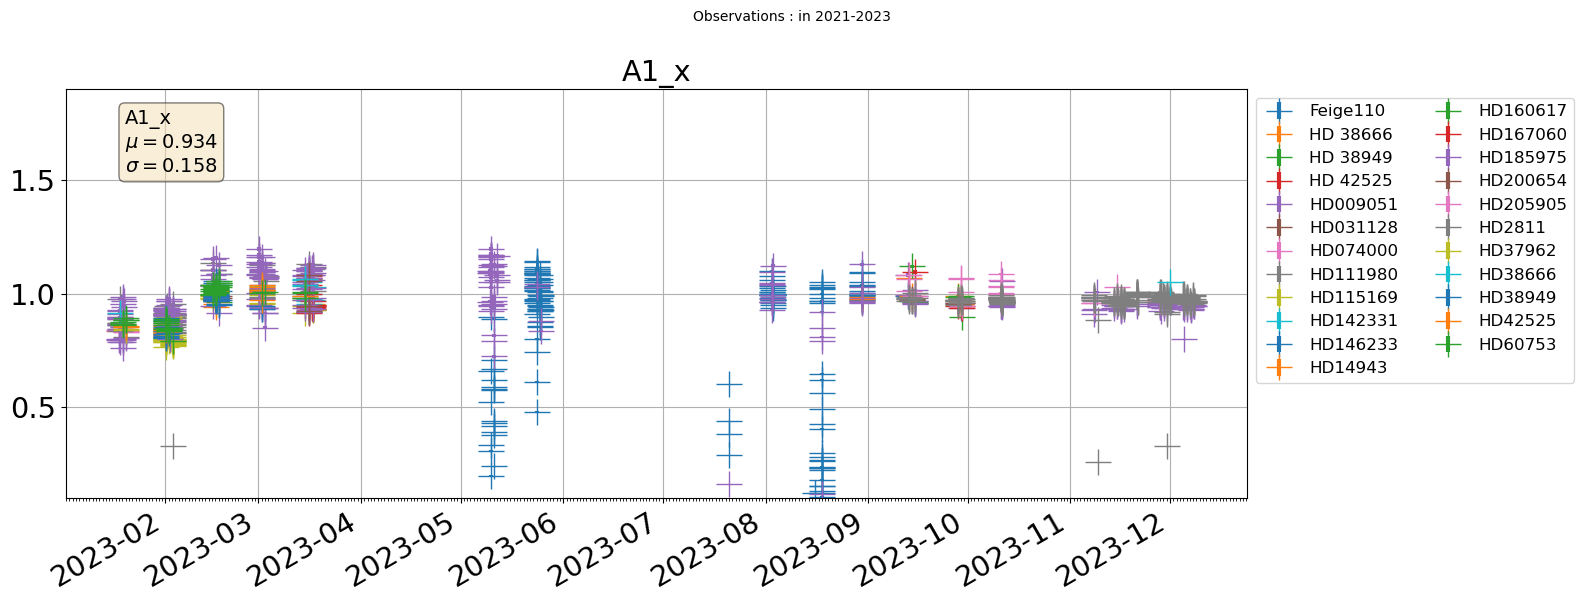

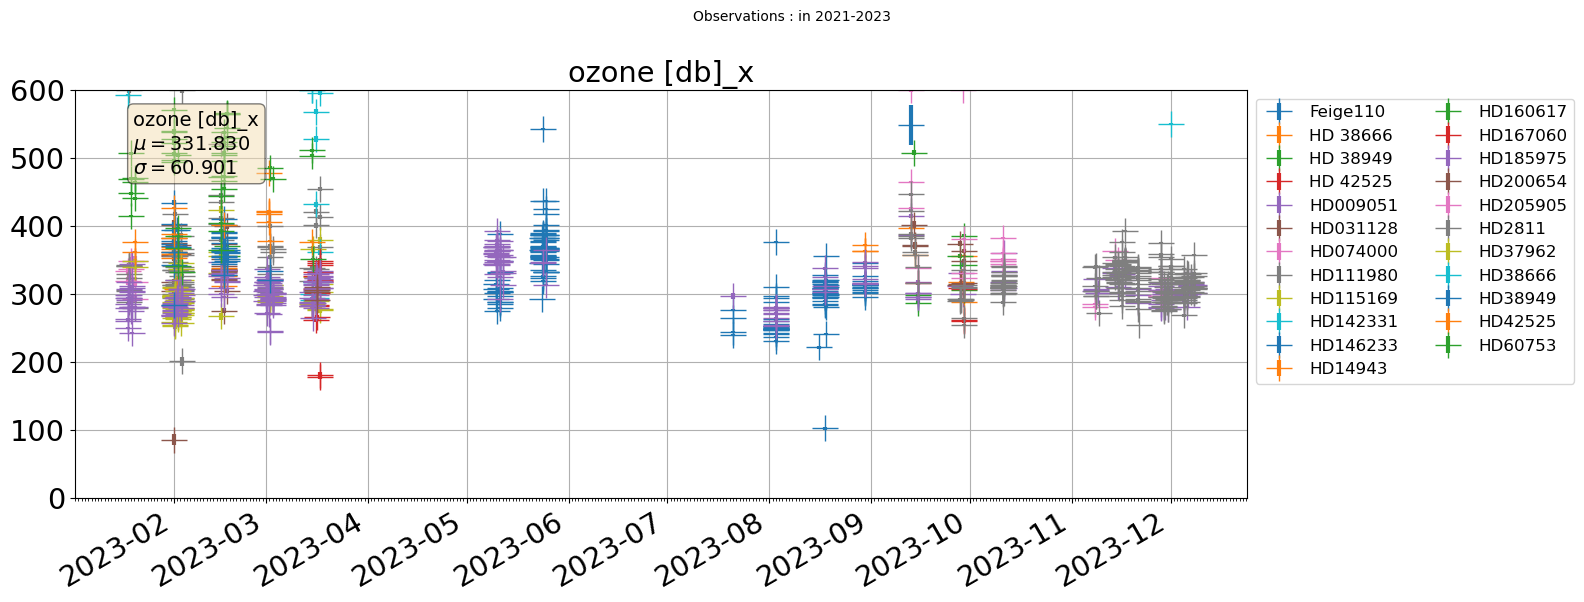

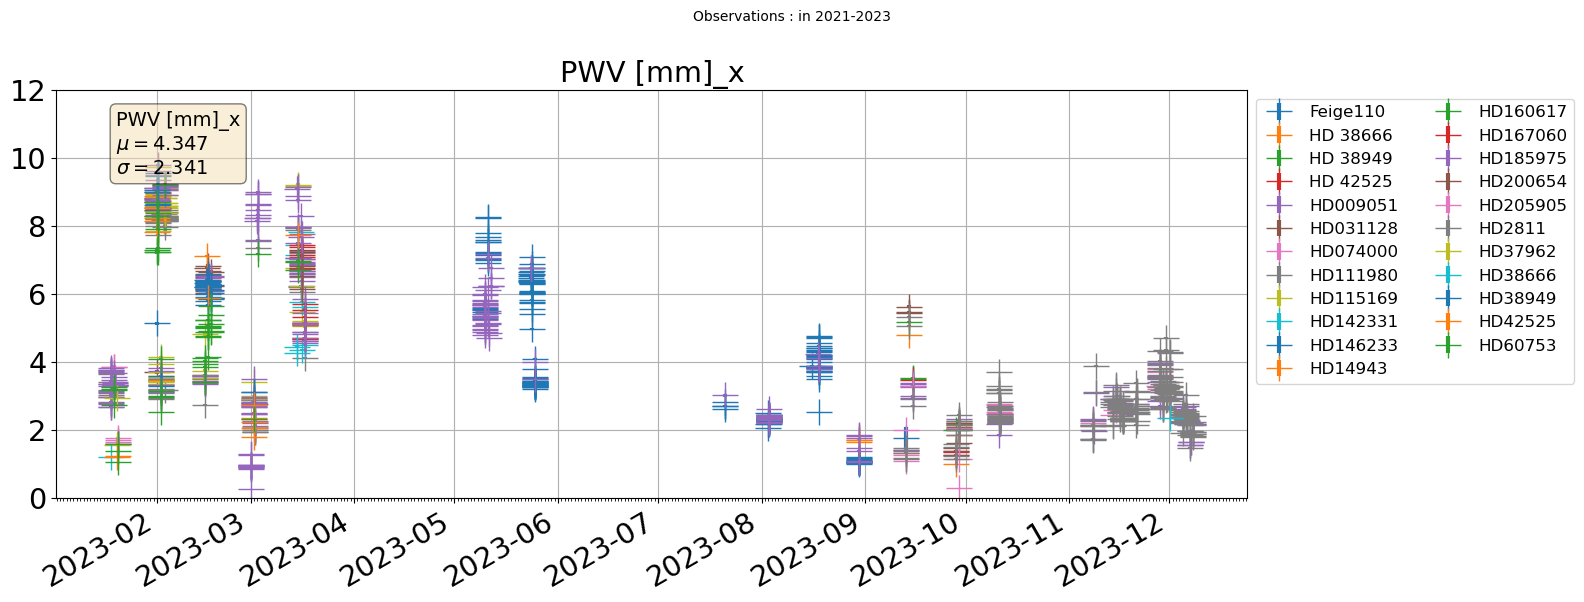

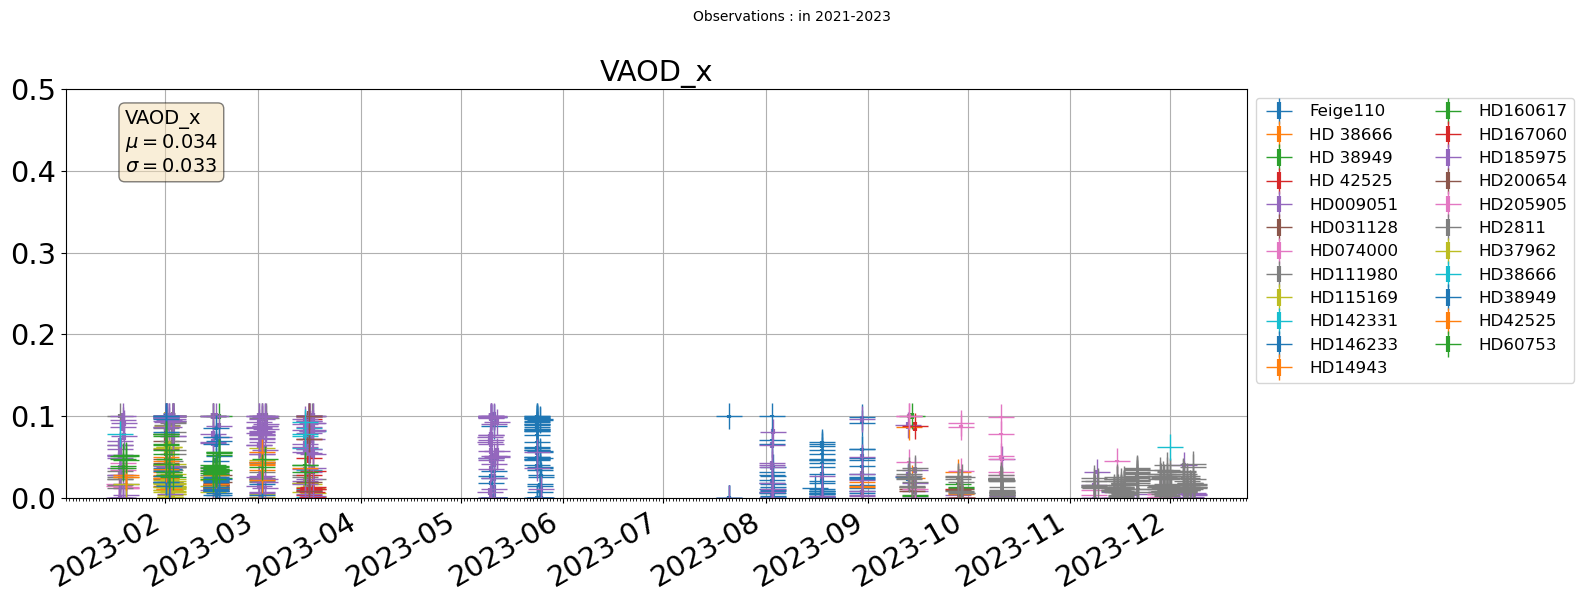

In [17]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## Merra2

    MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv

In [18]:
top_merra2 = "../../../Merra2"

In [19]:
asm_merra2 = [
    #"MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
    #"MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [20]:
aer_merra2 = [
    #"MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
    #"MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [21]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [22]:
df_asm[0].head()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
time,,,,,,,,,,,,,,,
2023-01-01 00:00:00,78620.320,284.24590,284.19403,267.12990,0.005727,0.0,2.642721e-05,5.599337,283.92380,1.750564,1.238044,2.038036,-0.090943,-0.012991,-0.419707
2023-01-01 01:00:00,78645.195,282.94003,282.63483,267.16120,0.005727,0.0,7.297844e-06,4.944884,282.22986,0.164982,0.114584,0.112569,0.002039,0.040294,-0.018076
2023-01-01 02:00:00,78658.790,282.69012,281.91070,266.89362,0.005721,0.0,1.972541e-06,4.232842,280.79850,-0.738192,-0.392655,-0.988660,-0.194765,-0.107497,-0.264359
2023-01-01 03:00:00,78664.510,282.95117,281.80444,266.16187,0.005706,0.0,5.257316e-07,3.744954,279.49896,-0.444341,-0.294611,-0.499962,-0.778797,-0.391749,-1.194732
2023-01-01 04:00:00,78652.450,283.03754,281.62714,265.97803,0.005702,0.0,9.333598e-08,3.388126,278.33760,-0.331920,-0.232934,-0.348620,-1.210167,-0.640487,-1.799269


In [23]:
df_aer[0].head()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
time,,,
2023-01-01 00:30:00,1.344682,0.048491,0.045733
2023-01-01 01:30:00,1.363253,0.044516,0.041716
2023-01-01 02:30:00,1.378122,0.040857,0.038042
2023-01-01 03:30:00,1.392257,0.038250,0.035439
2023-01-01 04:30:00,1.408844,0.036092,0.033277


In [24]:
df_asm[0].index

Index(['2023-01-01 00:00:00', '2023-01-01 01:00:00', '2023-01-01 02:00:00',
       '2023-01-01 03:00:00', '2023-01-01 04:00:00', '2023-01-01 05:00:00',
       '2023-01-01 06:00:00', '2023-01-01 07:00:00', '2023-01-01 08:00:00',
       '2023-01-01 09:00:00',
       ...
       '2023-12-31 14:00:00', '2023-12-31 15:00:00', '2023-12-31 16:00:00',
       '2023-12-31 17:00:00', '2023-12-31 18:00:00', '2023-12-31 19:00:00',
       '2023-12-31 20:00:00', '2023-12-31 21:00:00', '2023-12-31 22:00:00',
       '2023-12-31 23:00:00'],
      dtype='object', name='time', length=8760)

Text(0.5, 1.0, 'Merra2 Ozone')

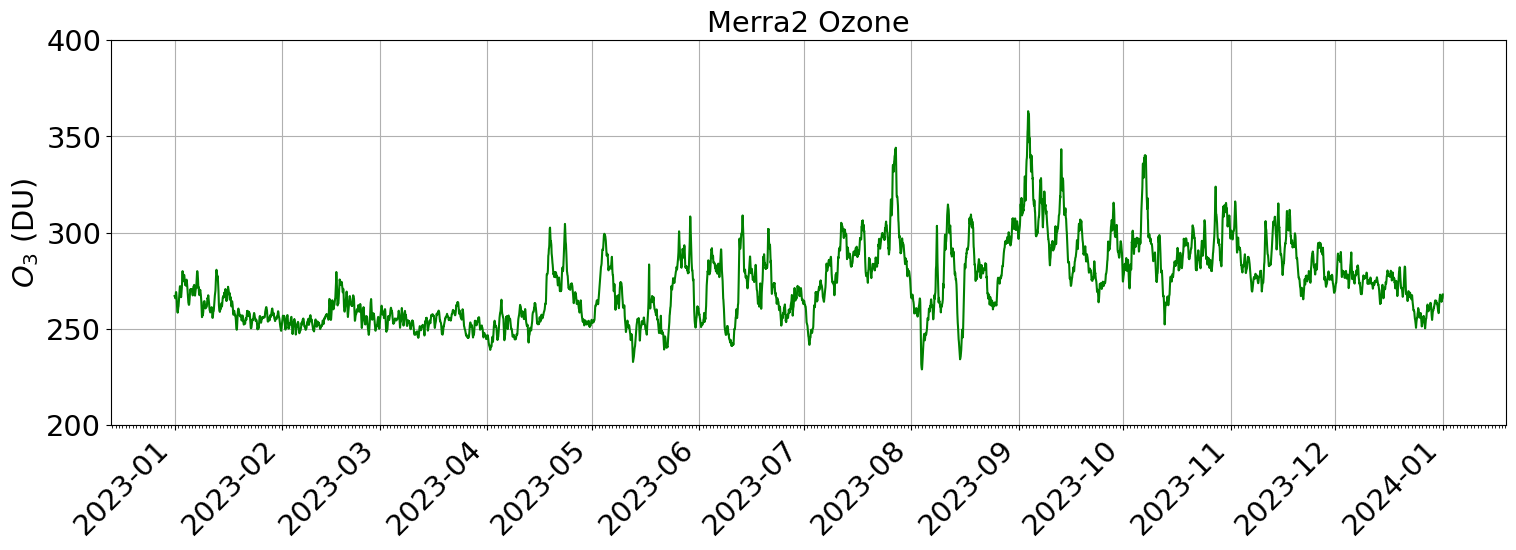

In [26]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');
ax.set_ylim(200.,400.)
ax.set_ylabel("$O_3$ (DU)")
ax.set_title("Merra2 Ozone")



In [ ]:
df["dateobs"].values

Text(0.5, 1.0, 'Merra2 Precipitable Water Vapor')

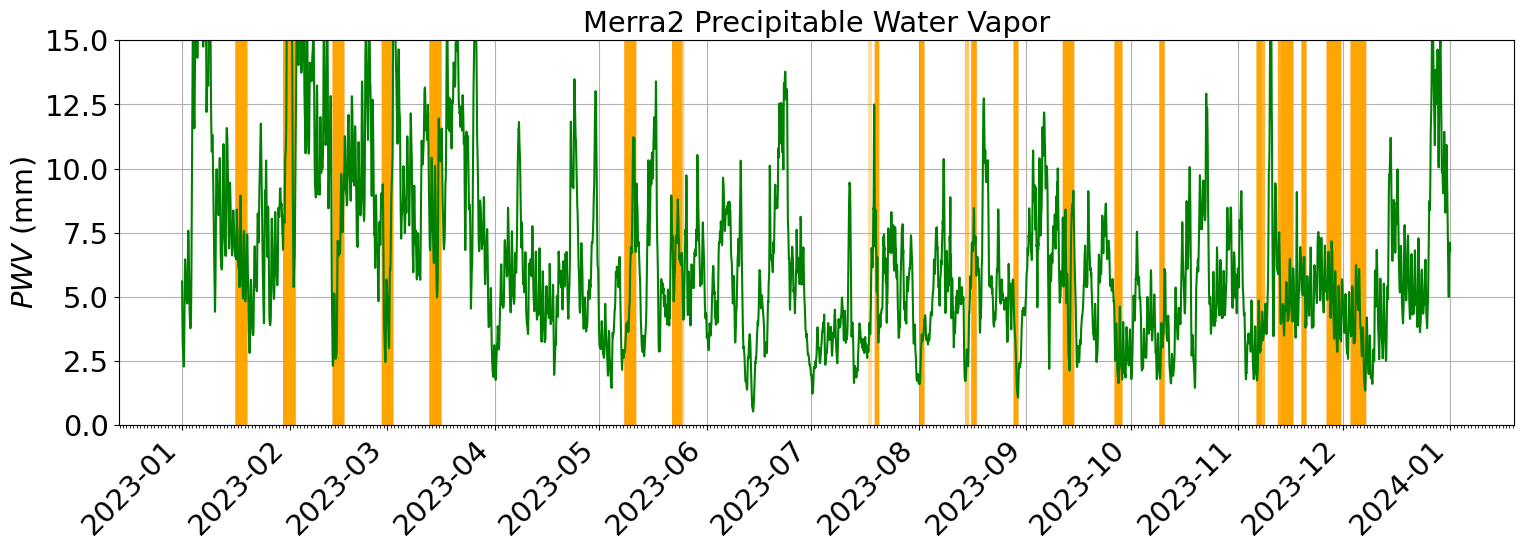

In [27]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,15.)
ax.set_ylabel("$PWV$ (mm)")
ax.set_title("Merra2 Precipitable Water Vapor")


Text(0.5, 1.0, 'Merra2 Aerosol Extinction')

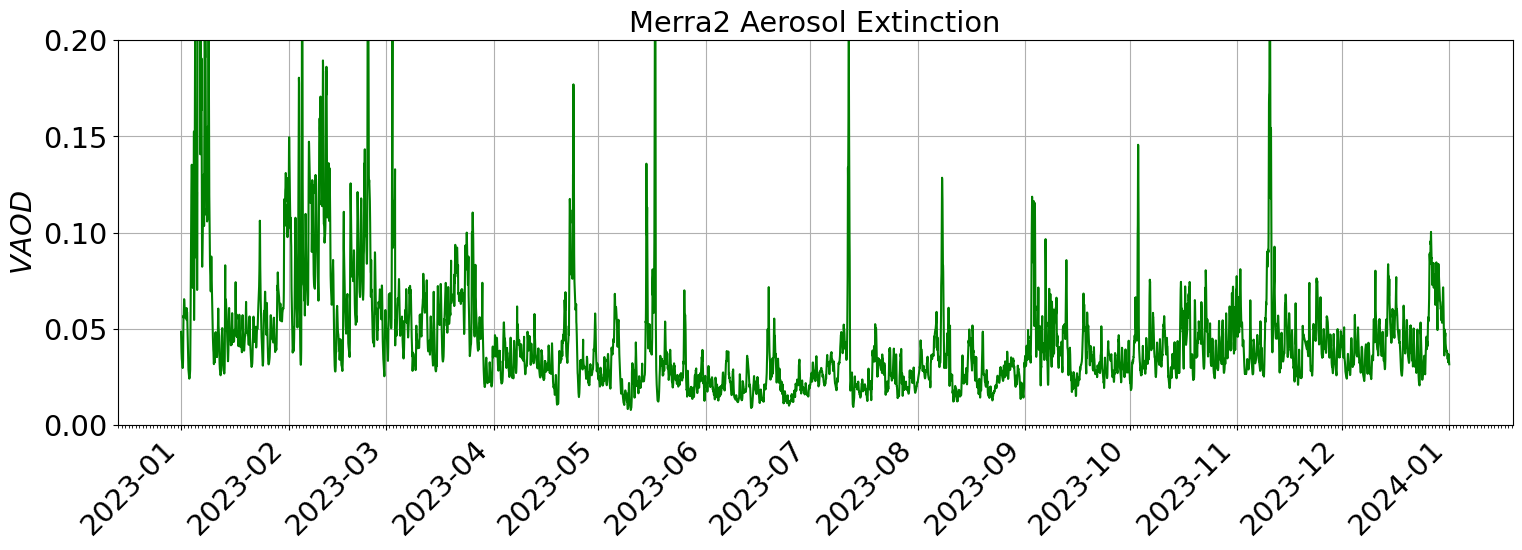

In [28]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTEXTTAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTEXTTAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTEXTTAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Extinction")

Text(0.5, 1.0, 'Merra2 Aerosol Scattering')

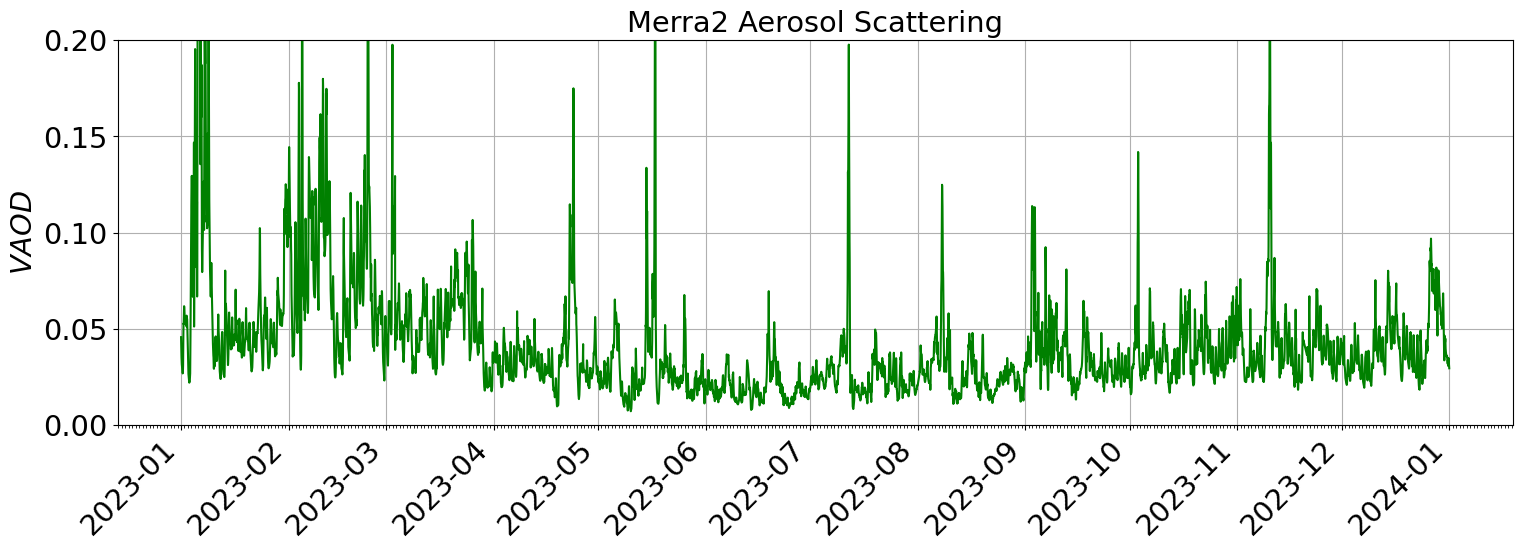

In [29]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

    
ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTSCATAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTSCATAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTSCATAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Scattering")

Text(0.5, 1.0, 'Merra2 Aerosol exponent')

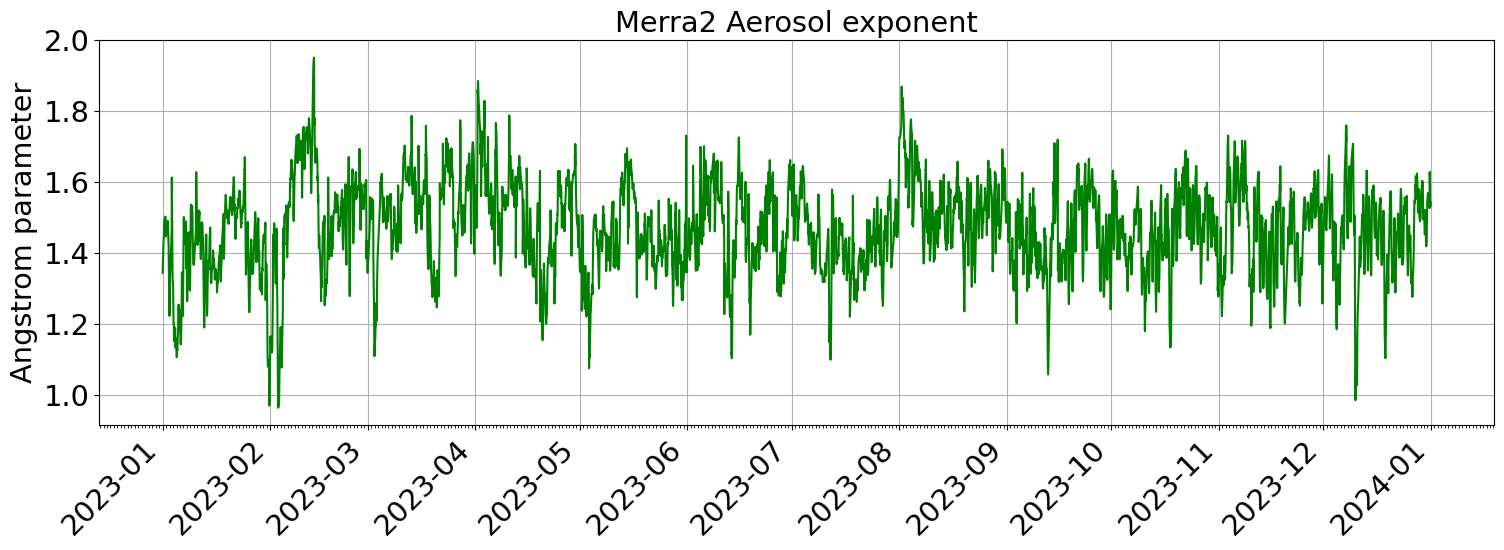

In [30]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTANGSTR,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTANGSTR,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTANGSTR,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

#ax.set_ylim(0.,2.)
ax.set_ylabel("Angstrom parameter")
ax.set_title("Merra2 Aerosol exponent")

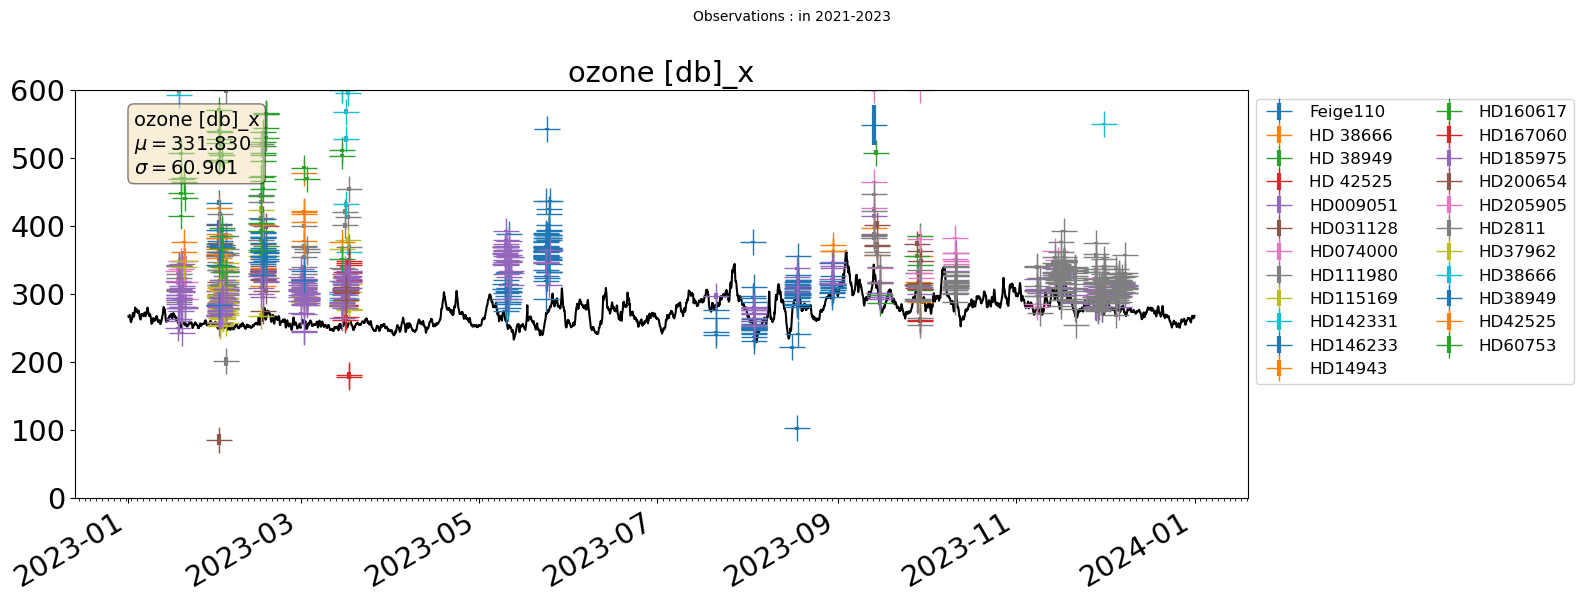

In [31]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

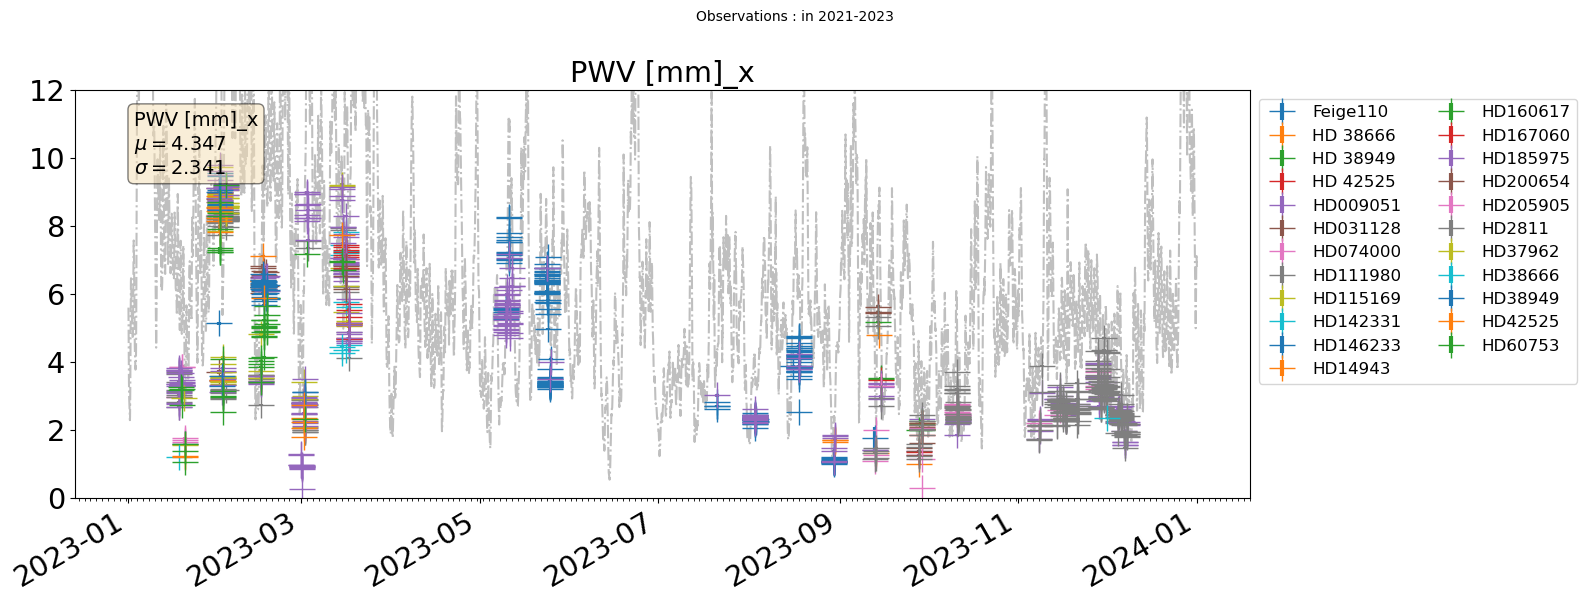

In [32]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()